In [1]:
import pickle
from tokenizers import BPETokenizer
import torch
from transformer import Transformer

In [2]:
VOCAB_SIZE = 1000

TOKENIZER_PATH = f"tokenizers/bpe_{VOCAB_SIZE}_optimal_tokenizer.pkl"
DATA_PATH = "../data/paul_graham_essay.txt"
TRAIN_DATA_PATH = f"bpe_{VOCAB_SIZE}_optimal_train.pt"
TEST_DATA_PATH = f"bpe_{VOCAB_SIZE}_optimal_test.pt"

DEVICE = "cuda"
EMBED_SIZE = 384
NUM_HEADS = 8
CONTEXT_LENGTH = 64
NUM_LAYERS = 12
BATCH_SIZE = 32

In [3]:
try:
    with open(TOKENIZER_PATH, "rb") as f:
        tokenizer = pickle.load(f)
except:
    tokenizer = BPETokenizer.build_tokenizer(DATA_PATH, VOCAB_SIZE)
    with open(TOKENIZER_PATH, "wb") as f:
        pickle.dump(tokenizer, f)

In [4]:
"asdas".encode("utf-8")

b'asdas'

In [5]:
root = {}
def insert(word):
    cur = root
    for c in word:
        cur[c] = cur.get(c, {})
        cur = cur[c]
    cur["end"] = True

def exist(word):
    cur = root
    for c in word:
        cur = cur.get(c)
        if cur is None:
            return False
    return cur.get("end", False)

In [6]:
tokenizer.inv_vocab = {v:k for k, v in tokenizer.vocab.items()}

In [7]:
for word in tokenizer.inv_vocab:
    insert(word[::-1])

In [8]:

def encode_v2(self, text):
    tokens = bytes(list(text.encode("utf-8")))
    n = len(tokens)
    dp = [i for i in range(1, n+1)] + [0]
    par = [i-1 for i in range(n)]
    for i in range(n):
        cur = root
        for j in range(i, -1, -1):
            cur = cur.get(tokens[j])
            if cur is None:
                break
            if cur.get("end", False):
                if dp[j-1] + 1 < dp[i]:
                    dp[i] = dp[j-1] +  1
                    par[i] = j-1
    new_tokens = []
    cur = n-1
    while cur != -1:
        new_tokens.append(self.inv_vocab[tokens[par[cur]+1: cur+1]])
        cur = par[cur]
    new_tokens.reverse()
    return new_tokens

In [9]:
tokenizer.encode("hi how are you")

[564, 32, 498, 459, 343]

In [10]:
encode_v2(tokenizer, "hi how are you")

[564, 32, 498, 459, 343]

In [11]:
try:
    train_data = torch.load(TRAIN_DATA_PATH)
    test_data = torch.load(TEST_DATA_PATH)
except:
    with open(DATA_PATH, "r") as f:
        data = f.read()
    # tokenized_data = torch.tensor(tokenizer.encode(data), dtype=torch.long)
    tokenized_data = torch.tensor(encode_v2(tokenizer, data), dtype=torch.long)
    n = int(0.9 * len(tokenized_data))
    train_data = tokenized_data[:n]
    test_data = tokenized_data[n:]
    torch.save(train_data, TRAIN_DATA_PATH)
    torch.save(test_data, TEST_DATA_PATH)

In [12]:
m = Transformer(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_heads=NUM_HEADS,
    context_length=CONTEXT_LENGTH,
    num_layers=NUM_LAYERS,
)
m.to(DEVICE)

Transformer(
  (token_embedding): Embedding(1000, 384)
  (pos_embedding): Embedding(64, 384)
  (attn_blocks): ModuleList(
    (0-11): 12 x AttentionBlock(
      (attn_heads): ModuleList(
        (0-7): 8 x CausalSelfAttention(
          (Q): Linear(in_features=384, out_features=48, bias=False)
          (K): Linear(in_features=384, out_features=48, bias=False)
          (V): Linear(in_features=384, out_features=48, bias=False)
        )
      )
      (mlp): MLP(
        (fcn): Linear(in_features=384, out_features=1536, bias=True)
        (activation): ReLU()
        (proj): Linear(in_features=1536, out_features=384, bias=True)
      )
      (layer_norm_1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
  (lm_head): Linear(in_features=384, out_features=1000, bias=False)
)

In [13]:
unif = torch.ones(train_data.shape[0] - CONTEXT_LENGTH, device=DEVICE)


def get_batch():
    batch_indices = unif.multinomial(BATCH_SIZE, replacement=False)
    inputs = torch.stack([train_data[i : i + CONTEXT_LENGTH] for i in batch_indices])
    targets = torch.stack(
        [train_data[i + 1 : i + 1 + CONTEXT_LENGTH] for i in batch_indices]
    )
    inputs = inputs.to(DEVICE)
    targets = targets.to(DEVICE)
    return inputs, targets


logits, loss = m(*get_batch())

In [14]:
logits.shape

torch.Size([32, 64, 1000])

In [15]:
loss.item()

7.106886386871338

In [16]:
start_idx = get_batch()[0]
print(start_idx)
m.generate(start_idx, 1)

tensor([[542, 637, 278,  ..., 410, 296, 682],
        [ 52, 732, 278,  ...,  45, 300, 118],
        [105, 273, 294,  ..., 723, 273, 487],
        ...,
        [118, 276, 621,  ..., 799, 296, 550],
        [ 66, 712, 672,  ..., 307, 105,  98],
        [309, 758, 731,  ..., 524, 110, 886]], device='cuda:0')


tensor([[542, 637, 278,  ..., 296, 682, 170],
        [ 52, 732, 278,  ..., 300, 118, 729],
        [105, 273, 294,  ..., 273, 487, 504],
        ...,
        [118, 276, 621,  ..., 296, 550, 191],
        [ 66, 712, 672,  ..., 105,  98, 313],
        [309, 758, 731,  ..., 110, 886, 604]], device='cuda:0')

In [17]:
with torch.no_grad():
    print(
        tokenizer.decode(
            m.generate(torch.tensor([encode_v2(tokenizer, "I was a")], device=DEVICE), 100)[
                0
            ].tolist()
        )
    )

I was a�s, ut ap�ati, and we I got fulstill ci�InI was gra�make d of �ound �a b're �out people oundmade rother �long and�ge�th surproblema�shit was HmoXYCst tter ldtter their �at y 

them thes�ought s, after �pamowas �membd

ic coualizal desitting few OdifferY ic\s and  K0 wto get at the encas asgi—know 


In [18]:
optim = torch.optim.AdamW(params=m.parameters(), lr=1e-4)

In [19]:
for step in range(1000):
    _, loss = m(*get_batch())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(loss.item())
with torch.no_grad():
    print(
        tokenizer.decode(
            m.generate(torch.tensor([encode_v2(tokenizer, "I was a")], device=DEVICE), 100)[
                0
            ].tolist()
        )
    )

7.134923458099365
6.253140449523926
6.113219738006592
4.643240928649902
4.112448215484619
3.5908052921295166
3.013568878173828
2.3879692554473877
1.7144330739974976
1.162097454071045
I was away for hous. My kriinputing to a h? E�working on this new ear of which made took able fience there even a every few years later, but qtur [7. What onwn as a things iners investpublishing againly obvanized. The Huhave saidentifially intenthey would even made investors were about proin the Now I realized for the ttknew understs they were 


In [20]:
# Let's do a 1000 more steps and see
for step in range(1000):
    _, loss = m(*get_batch())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(loss.item())
with torch.no_grad():
    print(
        tokenizer.decode(
            m.generate(torch.tensor([encode_v2(tokenizer, "I was a")], device=DEVICE), 100)[
                0
            ].tolist()
        )
    )

0.7036764025688171
0.5116625428199768
0.39318740367889404
0.3209279179573059
0.2617420554161072
0.24070613086223602
0.25220435857772827
0.2150314599275589
0.1945553869009018
0.16299012303352356
I was ave art day I was since anta leactuel investmentations, and a notiy. They to read in S-8write some software and never have finishe'd made them dealing the copy but college to server.

you could intenthese insteate was no idea that seemed let the founders paid of still 9ly alanswer that I learned some users retization, that I couldn't exc


In [21]:
# 1000 more?
for step in range(1000):
    _, loss = m(*get_batch())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(loss.item())
with torch.no_grad():
    print(
        tokenizer.decode(
            m.generate(torch.tensor([encode_v2(tokenizer, "I was a")], device=DEVICE), 100)[
                0
            ].tolist()
        )
    )

0.1760077327489853
0.17825593054294586
0.17376434803009033
0.152085542678833
0.14306595921516418
0.15635034441947937
0.12387169897556305
0.12796637415885925
0.14019951224327087
0.13738314807415009
I was aircrew the reitions I was about to discover.

I applied to 3 grad schools: MIT and after ally. And a lot work. [25 to continue my ks jeroom legineed. Wherages of doing one, we would have been so many ular known in a so. It. The specience of Lisp that it oncto, and then outI topic. In returned 


In [22]:
with torch.no_grad():
    print(
        tokenizer.decode(
            m.generate(
                torch.tensor(
                    [encode_v2(tokenizer, "I wanted not just to build things")],
                    device=DEVICE,
                ),
                100,
            )[0].tolist()
        )
    )

I wanted not just to build thingsycal-que sites of making paintings and living in New York.

I was nervous about money, because I could sense that Interleaf was on the way doage store hack for there was an upper to be between conventional oess is the optimate tried to her missaid I worked for VC that actually made with this HN, it who else 


In [25]:
len(train_data) + len(test_data)

24187

In [30]:
losses_optimal = [7.134923458099365,
 6.253140449523926,
 6.113219738006592,
 4.643240928649902,
 4.112448215484619,
 3.5908052921295166,
 3.013568878173828,
 2.3879692554473877,
 1.7144330739974976,
 1.162097454071045,
 0.7036764025688171,
 0.5116625428199768,
 0.39318740367889404,
 0.3209279179573059,
 0.2617420554161072,
 0.24070613086223602,
 0.25220435857772827,
 0.2150314599275589,
 0.1945553869009018,
 0.16299012303352356,
 0.1760077327489853,
 0.17825593054294586,
 0.17376434803009033,
 0.152085542678833,
 0.14306595921516418,
 0.15635034441947937,
 0.12387169897556305,
 0.12796637415885925,
 0.14019951224327087,
 0.13738314807415009]

In [31]:
losses_greedy = [7.061542987823486,
 6.245255470275879,
 5.356468677520752,
 4.347721099853516,
 3.8550236225128174,
 3.4973127841949463,
 2.962090253829956,
 2.2358956336975098,
 1.5125809907913208,
 0.9945037961006165,
 0.6650863289833069,
 0.48293110728263855,
 0.35592928528785706,
 0.31363072991371155,
 0.27621620893478394,
 0.2521527111530304,
 0.22401702404022217,
 0.21059758961200714,
 0.20255036652088165,
 0.18780313432216644,
 0.17992229759693146,
 0.16258060932159424,
 0.1676357239484787,
 0.16767027974128723,
 0.14056962728500366,
 0.16359587013721466,
 0.1349770575761795,
 0.13539303839206696,
 0.12565146386623383,
 0.13672854006290436]

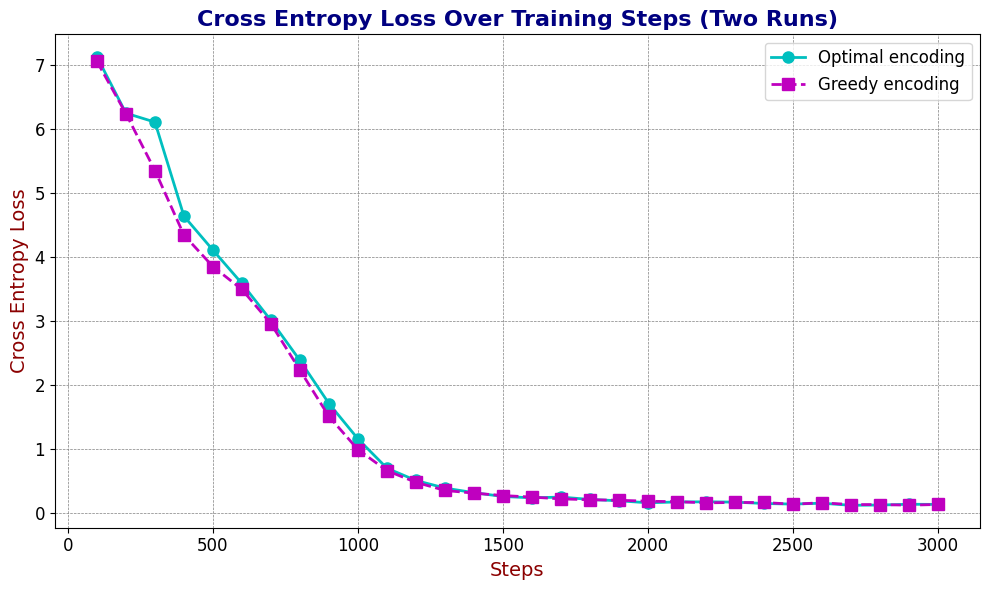

In [32]:
import matplotlib.pyplot as plt

# Create the step numbers for x-axis
steps = [i * 100 for i in range(1, len(losses_optimal) + 1)]

# Create the plot for two runs
plt.figure(figsize=(10, 6))
plt.plot(steps, losses_optimal, color='c', marker='o', linestyle='-', linewidth=2, markersize=8, label='Optimal encoding')
plt.plot(steps, losses_greedy, color='m', marker='s', linestyle='--', linewidth=2, markersize=8, label='Greedy encoding')

# Customize the plot
plt.title('Cross Entropy Loss Over Training Steps (Two Runs)', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Steps', fontsize=14, color='darkred')
plt.ylabel('Cross Entropy Loss', fontsize=14, color='darkred')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
